# Problem Statement

A young entrepreneur in New York city is wanting to open a mobile pest control business with a strong focus on food industry. The business concept is chosen to have employees travelling to the customers by escooters or ebikes allowing for extra savings on fleet and travel time as well as other costs associated. However a basic requirement for storage and cleaning facilities are stated as follows :
- The location for the base needs to be chosen as closely to the most of the job locations as possible
- Location detailed down to a neighborhood level

The task will involve some exploratory analysis of Food Venues in NY as well as the potential in the services required.

The final results will be used for other pest control businesses with a different set of requirements but also specialiased in Food Businesses. This report is targeted to help the Restaurant owners to identify potential areas suitable to open a bar or cafe.

# DATA

## Dataset 1

The data we are going to use is a Foursquare API data retieval consisting of venues and categories of venues in the whole New York city

## Dataset 2

The second dataset is a NYC Rat Sightings dataset freely available on https://www.kaggle.com/new-york-city/nyc-rat-sightings

New York City rodent complaints can be made online, or by dialing 3-1-1, and the New York City guide Preventing Rats on Your Property discusses how the New York City Health Department inspects private and public properties for rats. Property owners that fail inspections receive a Commissioner's Order and have five days to correct the problem. If after five days the property fails a second inspection, the owner receives a Notice of Violation and can be fined. The property owner is billed for any clean-up or extermination carried out by the Health Department.

Data is from 2010-Sept 16th, 2017 and includes date, location (lat/lon), type of structure, borough, and community board.

## Dataset 3

New York Borough data in JSON format

## Dataset 4

NYC zip codes for each Borough

# Methodology

As the methodology we chose to combine the data from the New York city Neighborhoods geo information and utilize a Foursquare API to get the list of venues in each neighborhood .
Consequtively we performed some analysis on the resulting data table to select only food related venues from the whole list followed by grouping it and combining into total Food Venues for Borough and Neighborhood.
We had to utilize the NYC zipcodes to join the two tables on the zip code to get the resulting table of rat sightings and food venues.
As the main KPI for the business problem we chose the ratio of Rats sightings for each venue and borough. 
A sorting technique was performed to sort the results so that we have a descending table.

Installing necessary tools and libraries


In [11]:
!pip install geopy
!pip install folium
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

You should consider upgrading via the 'c:\users\vlads\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


Libraries imported.


You should consider upgrading via the 'c:\users\vlads\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


Importing Borough Data

In [12]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [13]:
neighborhoods_data = newyork_data['features']

Building a data table to be used for a Foursquare request

In [14]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [15]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [16]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Performing API request

In [ ]:
CLIENT_ID = '**' # your Foursquare ID
CLIENT_SECRET = '**' # your Foursquare Secret
VERSION = '20210523' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Error: Session cannot generate requests

In [18]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


In [ ]:
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

Error: Session cannot generate requests

RESULTS FROM API:

In [20]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60b1749b8a2eba3af99d626d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Wakefield',
  'headerFullLocation': 'Wakefield, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 8,
  'suggestedBounds': {'ne': {'lat': 40.899205181110005,
    'lng': -73.84125857127495},
   'sw': {'lat': 40.89020517211, 'lng': -73.8531424698231}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c537892fd2ea593cb077a28',
       'name': 'Lollipops Gelato',
       'location': {'address': '4120 Baychester Ave',
        'crossStreet': 'Edenwald & Bussing Ave',
        'lat': 40.894123150205274,
        'lng': -73.84589162362325,
        'labeledLatLn

Defining function for building the venue table


In [21]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Results of the table:

In [22]:
venues = results['response']['groups'][0]['items']

    
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues
# # filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-22-3d32d806770d>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Lollipops Gelato,Dessert Shop,40.894123,-73.845892
1,Rite Aid,Pharmacy,40.896649,-73.844846
2,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568
3,Walgreens,Pharmacy,40.896528,-73.844700
4,Dunkin',Donut Shop,40.890459,-73.849089


In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

8 venues were returned by Foursquare.


Performing this function on each Neighborhood

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
nearby_venues

,name,categories,lat,lng
0,Lollipops Gelato,Dessert Shop,40.894123,-73.845892
1,Rite Aid,Pharmacy,40.896649,-73.844846
2,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568
3,Walgreens,Pharmacy,40.896528,-73.844700
4,Dunkin',Donut Shop,40.890459,-73.849089
5,Subway,Sandwich Place,40.890468,-73.849152
6,Central Deli,Deli / Bodega,40.896728,-73.844387
7,Koss Quick Wash,Laundromat,40.891281,-73.849904


In [25]:
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

GROUPING AND COUNTING

In [26]:
ny_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,27,27,27,27,27,27
Annadale,10,10,10,10,10,10
Arden Heights,4,4,4,4,4,4
Arlington,4,4,4,4,4,4
Arrochar,21,21,21,21,21,21
Arverne,21,21,21,21,21,21
Astoria,100,100,100,100,100,100
Astoria Heights,11,11,11,11,11,11
Auburndale,21,21,21,21,21,21


In [27]:
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))

There are 435 uniques categories.


We do one hot Encoding to calculate and descriminate against non-food related venues

In [28]:
# one hot encoding
ny_venues_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_venues_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_venues_onehot.columns[-1]] + list(ny_venues_onehot.columns[:-1])
ny_venues_onehot = ny_venues_onehot[fixed_columns]
ny_venues_onehot.set_index('Neighborhood')

ny_venues_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaura

In [29]:
ny_venues_onehot1=ny_venues_onehot.groupby(by='Neighborhood', axis=0).sum()
ny_venues_onehot1.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Ope

In [30]:
ny_food = ny_venues_onehot1.loc[:, ny_venues_onehot1.columns.str.contains('Restaurant|Bar|pizza|bakery|taco|bbq', case=False)]
ny_food.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bakery,Bar,Beach Bar,Beer Bar,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cocktail Bar,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dive Bar,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gay Bar,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hookah Bar,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Piano Bar,Pizza Place,Polish Restaurant,Puerto Rican Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Sake Bar,Salon / Barbershop,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tiki Bar,Turkish Restaurant,Udon Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yemeni Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
ny_food_totals = ny_food.sum(axis=1)
ny_food_totals_df=ny_food_totals.to_frame()

Food venues in each Neighborhood

In [32]:
ny_food_totals_df.rename(columns={0:'Food_locs'})

,Food_locs
Neighborhood,
Allerton,7
Annadale,5
Arden Heights,1
Arlington,1
Arrochar,7
Arverne,4
Astoria,58
Astoria Heights,3
Auburndale,7


Loading the Rat Sigthing Data

In [35]:
rats = pd.read_csv(r'Rat_Sightings.csv')

In [36]:
rats.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,31464015,09/04/2015 12:00:00 AM,09/18/2015 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Mixed Use Building,10006.0,NaN,NaN,NaN,NaN,TRINITY PLACE,RECTOR STREET,INTERSECTION,NEW YORK,NaN,NaN,Closed,10/04/2015 03:01:02 PM,09/18/2015 12:00:00 AM,01 MANHATTAN,MANHATTAN,980656.0,197137.0,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.707772,-74.012963,"(40.70777155363643, -74.01296309970473)"
1,31464024,09/04/2015 12:00:00 AM,10/28/2015 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Commercial Building,10306.0,2270 HYLAN BOULEVARD,HYLAN BOULEVARD,NaN,NaN,NaN,NaN,LATLONG,STATEN ISLAND,NaN,NaN,Closed,10/04/2015 10:02:58 AM,10/28/2015 12:00:00 AM,Unspecified STATEN ISLAND,STATEN ISLAND,955207.0,148858.0,Unspecified,STATEN ISLAND,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.575209,-74.104547,"(40.575209242947444, -74.1045465185469)"
2,31464025,09/04/2015 12:00:00 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,1-2 Family Dwelling,10310.0,758 POST AVENUE,POST AVENUE,CARY AVENUE,GREENLEAF AVENUE,NaN,NaN,ADDRESS,STATEN ISLAND,NaN,NaN,Assigned,10/04/2015 11:58:02 AM,09/04/2015 12:03:49 PM,01 STATEN ISLAND,STATEN ISLAND,949033.0,169278.0,Unspecified,STATEN ISLAND,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.631236,-74.126878,"(40.63123555151668, -74.12687759748677)"
3,31464026,09/04/2015 12:00:00 AM,09/14/2015 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11206.0,198 SCHOLES STREET,SCHOLES STREET,HUMBOLDT STREET,BUSHWICK AVENUE,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,10/04/2015 06:56:34 AM,09/14/2015 12:00:00 AM,01 BROOKLYN,BROOKLYN,1000550.0,197585.0,Unspecified,BROOKLYN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.708987,-73.941207,"(40.70898692345805, -73.94120690238431)"
4,31464027,09/04/2015 12:00:00 AM,09/22/2015 12:00:00 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Mixed Use Building,10462.0,2138 WALLACE AVENUE,WALLACE AVENUE,BRADY AVENUE,LYDIG AVENUE,NaN,NaN,ADDRESS,BRONX,NaN,NaN,Closed,10/04/2015 10:08:27 AM,09/22/2015 12:00:00 AM,11 BRONX,BRONX,1021648.0,250489.0,Unspecified,BRONX,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.854130,-73.864813,"(40.85413014360452, -73.86481331044513)"


In [37]:
zipsum=rats.groupby('Incident Zip').sum()

In [38]:
rats_sum = rats['Incident Zip'].value_counts()

In [39]:
!pip install bs4

You should consider upgrading via the 'c:\users\vlads\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [40]:
from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page
import pandas as pd 

Web Scraping ZIP codes

In [41]:
url = "https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php"
data  = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")
tables = soup.find_all('table') # in html table is represented by the tag <table>
len(tables)

1

In [42]:
!pip install html5lib
!pip install lxml
!pip install beautifulSoup4

import html5lib
import lxml
from bs4 import BeautifulSoup
url = "https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php"
dataframe_list = pd.read_html(url, flavor='bs4')

You should consider upgrading via the 'c:\users\vlads\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\vlads\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\vlads\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [43]:
import html5lib
url = "https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php"

In [44]:
dataframe_list = pd.read_html(url, flavor='bs4')

In [45]:
zip_all=dataframe_list[0]
        

In [47]:
zip_all
pd.options.display.max_rows = 20

In [48]:

zip1=zip_all.iloc[:,0:2]
zip2=zip_all.iloc[:,3:5]

In [49]:
zip2.rename(columns={3:'zip', 4:'borough'},inplace=True)

In [50]:
zip1.rename(columns={0:'zip', 1:'borough'},inplace=True)

In [51]:
zip_clean=pd.concat([zip1,zip2], axis=0)

We get the zip codes for each borough

In [52]:
zip_clean.set_index('zip')


,borough
zip,
10001,Manhattan
10002,Manhattan
10003,Manhattan
10004,Manhattan
10005,Manhattan
...,...
10309,Staten
10310,Staten
10311,Staten


In [54]:
zip_clean.set_index('zip', drop=True,inplace=True)

In [55]:
zip_clean

,borough
zip,
10001,Manhattan
10002,Manhattan
10003,Manhattan
10004,Manhattan
10005,Manhattan
...,...
10309,Staten
10310,Staten
10311,Staten


In [56]:
rats_sum_df=rats_sum.to_frame()

In [57]:
rats_sum_df

,Incident Zip
11221.0,3124
11216.0,2494
10025.0,2285
11238.0,2158
11233.0,1925
...,...
10271.0,1
1123.0,1
11242.0,1
11202.0,1


Data wrangling and cleaning

In [58]:
rats_sum_df.rename(columns={'Incident Zip':'Number', 'index':'zip'}, inplace=True)

In [60]:
zip1=zip_all.iloc[:,0:2]
zip2=zip_all.iloc[:,3:5]

In [61]:
zip2.rename(columns={3:'zip', 4:'borough'},inplace=True)

In [62]:
zip1.rename(columns={0:'zip', 1:'borough'},inplace=True)

In [63]:
zip_clean=pd.concat([zip1,zip2], axis=0)

In [64]:
zip_clean.head()

,zip,borough
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan


In [65]:
rats_sum1=rats_sum.to_frame()
rats_sum1.reset_index(inplace=True)
rats_sum1.head()

,index,Incident Zip
0,11221.0,3124
1,11216.0,2494
2,10025.0,2285
3,11238.0,2158
4,11233.0,1925


In [66]:
rats_sum1.rename(columns={'Incident Zip':'Number', 'index':'zip'}, inplace=True)

In [68]:
rats_sum1=rats_sum1.astype(int)
rats_sum1.head()

,zip,Number
0,11221,3124
1,11216,2494
2,10025,2285
3,11238,2158
4,11233,1925


In [85]:
rats_data=rats_sum1.merge(zip_clean, on='zip', how='right')

In [70]:
merged_geo_food=ny_food_totals_df.merge(neighborhoods, on='Neighborhood', how='right')

In [99]:
rats_data.drop_duplicates(subset=['zip','borough'], keep='first')
rats_final=rats_data.groupby('borough').agg({'Number':'sum'}).reset_index()

In [100]:

rats_final

,borough,Number
0,Bronx,41332.0
1,Brooklyn,69136.0
2,Manhattan,52352.0
3,Queens,29412.0
4,Staten,9792.0


In [101]:
rats_final.rename(columns={'borough' :'Borough'}, inplace=True)
borough_venues=merged_geo_food.groupby('Borough').sum()


,Neighborhood,0,Borough,Latitude,Longitude,Number
0,Wakefield,0.0,Bronx,40.894705,-73.847201,41332.0
1,Co-op City,4.0,Bronx,40.874294,-73.829939,41332.0
2,Eastchester,7.0,Bronx,40.887556,-73.827806,41332.0
3,Fieldston,0.0,Bronx,40.895437,-73.905643,41332.0
4,Riverdale,0.0,Bronx,40.890834,-73.912585,41332.0
...,...,...,...,...,...,...
301,Hudson Yards,20.0,Manhattan,40.756658,-74.000111,52352.0
302,Hammels,1.0,Queens,40.587338,-73.805530,29412.0
303,Bayswater,0.0,Queens,40.611322,-73.765968,29412.0
304,Queensbridge,3.0,Queens,40.756091,-73.945631,29412.0


In [108]:
foodrats_merged.rename(columns={0:'Food Venues', 'Number':'RatsNum'},inplace=True)

In [118]:
foodrats_merged


,Neighborhood,Food Venues,Borough,Latitude,Longitude,RatsNum
0,Wakefield,0,Bronx,40.894705,-73.847201,41332
1,Co-op City,4,Bronx,40.874294,-73.829939,41332
2,Eastchester,7,Bronx,40.887556,-73.827806,41332
3,Fieldston,0,Bronx,40.895437,-73.905643,41332
4,Riverdale,0,Bronx,40.890834,-73.912585,41332
...,...,...,...,...,...,...
301,Hudson Yards,20,Manhattan,40.756658,-74.000111,52352
302,Hammels,1,Queens,40.587338,-73.805530,29412
303,Bayswater,0,Queens,40.611322,-73.765968,29412
304,Queensbridge,3,Queens,40.756091,-73.945631,29412


In [112]:
foodrats_merged_clean=foodrats_merged.loc[:,['Neighborhood', 'Food Venues','Borough','RatsNum']]

In [120]:
nan_value = float("NaN")

foodrats_merged_clean.dropna(subset = ["RatsNum",'Food Venues'], inplace=True)

In [123]:
cols = ['Food Venues', 'RatsNum']
for col in cols:
    foodrats_merged_clean[col] = foodrats_merged_clean[col].apply(lambda x: int(x) if x == x else "")
    

In [126]:
foodrats_merged_clean=foodrats_merged_clean.drop_duplicates(subset=['Neighborhood'])

Final data table of the Pest data and Food venues

In [128]:
foodrats_merged_clean.sort_values(by=['Food Venues','RatsNum'], ascending=False)

,Neighborhood,Food Venues,Borough,RatsNum
115,Murray Hill,79,Manhattan,52352
118,East Village,60,Manhattan,52352
129,Astoria,58,Queens,29412
97,South Side,57,Brooklyn,69136
100,Chinatown,57,Manhattan,52352
...,...,...,...,...
183,Jamaica Estates,0,Queens,29412
192,Somerville,0,Queens,29412
193,Brookville,0,Queens,29412
294,Malba,0,Queens,29412


Performing the Ratio calculation

In [ ]:
foodrats_merged_clean['Venue Rat Ratio'] = (foodrats_merged_clean['Food Venues'] / foodrats_merged_clean['RatsNum']) * 1000
resultdf=foodrats_merged_clean.sort_values(by='Venue Rat Ratio', ascending=False).head(5)

Error: Session cannot generate requests

# Results

As we can see in the final results  the most pest infested and food business dense areas are Astoria and Sunnyside Gardens

<BarContainer object of 5 artists>

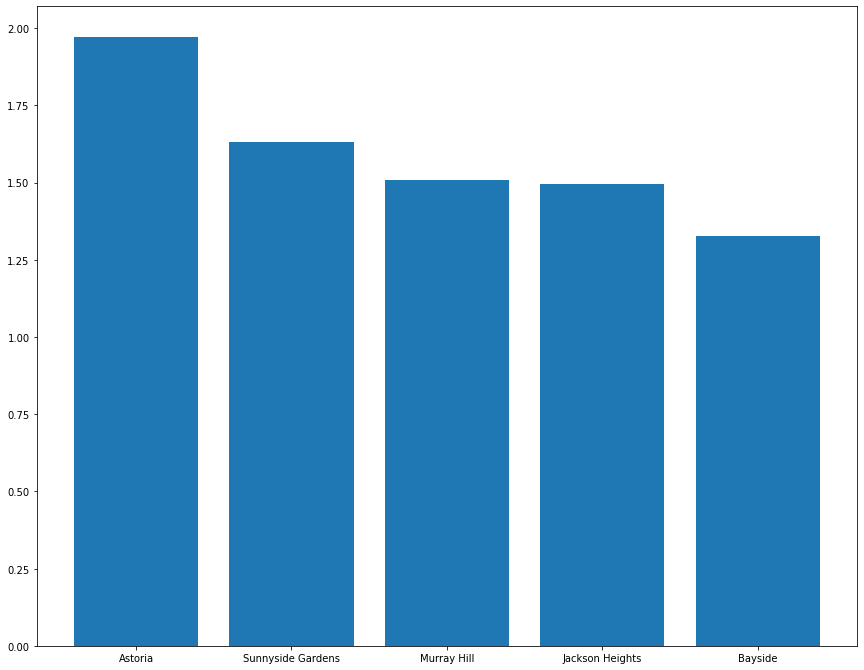

In [155]:
import matplotlib.pyplot as plt
names = resultdf['Neighborhood']
values = resultdf['Venue Rat Ratio']

plt.figure(figsize=(50, 40))

plt.subplot(333)
plt.bar(names, values)

# Discussion

During the data mining we have discovered that Queens, Manhattan and Bronx have the most food venues with most pests sigthed.
However after performing some data analysis purely on the rats data we found that Brooklyn is the most infested Borough. However our business problem was to prioritize the food venues which made the Neighborhood of Astoria that is part of Queens our top suggestion.
Manhattan is also very much affected by the pests which made Murray Hill into top 3 neighborhood option.


# Conclusion

It is clearly seen that Astoria has a almost a 2 point score in our chosen KPI for the pest rating which means that for the unit of food venue it has most pests observed and indicates an apparent business opportunity for our customer. Also it indicates for potential food business owners to avoid Manhattan and Queens for food safety compiance purposes